The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0


# Attention Pooling
:label:`sec_attention-pooling`

Now you know the major components of attention mechanisms under the framework in :numref:`fig_qkv`.
To recapitulate,
the interactions between
queries (volitional cues) and keys (nonvolitional cues)
result in *attention pooling*.
The attention pooling selectively aggregates values (sensory inputs) to produce the output.
In this section,
we will describe attention pooling in greater detail
to give you a high-level view of
how attention mechanisms work in practice.
Specifically,
the Nadaraya-Watson kernel regression model
proposed in 1964
is a simple yet complete example
for demonstrating machine learning with attention mechanisms.


In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l

## [**Generating the Dataset**]

To keep things simple,
let's consider the following regression problem:
given a dataset of input-output pairs $\{(x_1, y_1), \ldots, (x_n, y_n)\}$,
how to learn $f$ to predict the output $\hat{y} = f(x)$ for any new input $x$?

Here we generate an artificial dataset according to the following nonlinear function with the noise term $\epsilon$:

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

where $\epsilon$ obeys a normal distribution with zero mean and standard deviation 0.5.
Both 50 training examples and 50 validation examples
are generated.
To better visualize the pattern of attention later, the training inputs are sorted.


In [2]:
class NonlinearData(d2l.DataModule):
    def __init__(self, n, batch_size):
        self.save_hyperparameters()
        f = lambda x: 2 * tf.sin(x) + x**0.8
        self.x_train = tf.sort(tf.random.uniform((n,1)) * 5, 0)
        self.y_train = f(self.x_train) + tf.random.normal((n,1))
        self.x_val = tf.range(0, 5, 5.0/n)
        self.y_val = f(self.x_val)

    def get_dataloader(self, train):
        arrays = (self.x_train, self.y_train) if train else (self.x_val, self.y_val)
        return self.get_tensorloader(arrays, train)

n = 50
data = NonlinearData(n, batch_size=10)

The following function plots all the training examples (represented by circles),
the ground-truth data generation function `f` without the noise term (labeled by "Truth"), and the learned prediction function (labeled by "Pred").


In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(data.x_val, [data.y_val, y_hat.numpy()], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(data.x_train, data.y_train, 'o', alpha=0.5);

## Average Pooling

We begin with perhaps the world's "dumbest" estimator for this regression problem:
using average pooling to average over all the training outputs:

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$
:eqlabel:`eq_avg-pooling`

which is plotted below. As we can see, this estimator is indeed not so smart.


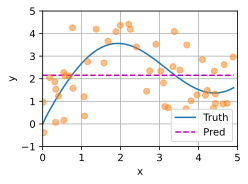

In [4]:
y_hat = tf.repeat(tf.reduce_mean(data.y_train), n)
plot_kernel_reg(y_hat)

## [**Nonparametric Attention Pooling**]

Obviously,
average pooling omits the inputs $x_i$.
A better idea was proposed
by Nadaraya :cite:`Nadaraya.1964`
and Watson :cite:`Watson.1964`
to weigh the outputs $y_i$ according to their input locations:

$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$
:eqlabel:`eq_nadaraya-watson`

where $K$ is a *kernel*.
The estimator in :eqref:`eq_nadaraya-watson`
is called *Nadaraya-Watson kernel regression*.
Here we will not dive into details of kernels.
Recall the framework of attention mechanisms in :numref:`fig_qkv`.
From the perspective of attention,
we can rewrite :eqref:`eq_nadaraya-watson`
in a more generalized form of *attention pooling*:

$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$
:eqlabel:`eq_attn-pooling`


where $x$ is the query and $(x_i, y_i)$ is the key-value pair.
Comparing :eqref:`eq_attn-pooling` and :eqref:`eq_avg-pooling`,
the attention pooling here
is a weighted average of values $y_i$.
The *attention weight* $\alpha(x, x_i)$
in :eqref:`eq_attn-pooling`
is assigned to the corresponding value $y_i$
based on the interaction
between the query $x$ and the key $x_i$
modeled by $\alpha$.
For any query, its attention weights over all the key-value pairs are a valid probability distribution: they are non-negative and sum up to one.

To gain intuitions of attention pooling,
just consider a *Gaussian kernel* defined as

$$
K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).
$$


Plugging the Gaussian kernel into
:eqref:`eq_attn-pooling` and
:eqref:`eq_nadaraya-watson` gives

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$
:eqlabel:`eq_nadaraya-watson-gaussian`

In :eqref:`eq_nadaraya-watson-gaussian`,
a key $x_i$ that is closer to the given query $x$ will get
*more attention* via a *larger attention weight* assigned to the key's corresponding value $y_i$.

Notably, Nadaraya-Watson kernel regression is a nonparametric model;
thus :eqref:`eq_nadaraya-watson-gaussian`
is an example of *nonparametric attention pooling*.
In the following, we plot the prediction based on this
nonparametric attention model.
The predicted line is smooth and closer to the ground-truth than that produced by average pooling.


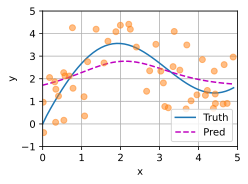

In [5]:
def diff(queries, keys):
    return tf.reshape(queries, (-1, 1)) - tf.reshape(keys, (1, -1))

def attention_pool(query_key_diffs, values):
    attention_weights = tf.nn.softmax(- query_key_diffs**2/2, axis=1)
    return tf.matmul(attention_weights, values), attention_weights

y_hat, attention_weights = attention_pool(
    diff(data.x_val, data.x_train), data.y_train)
plot_kernel_reg(y_hat)

Now let's take a look at the [**attention weights**].
Here validation inputs are queries while training inputs are keys.
Since both inputs are sorted,
we can see that the closer the query-key pair is,
the higher attention weight is in the attention pooling.


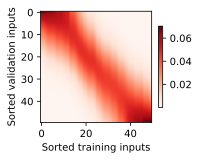

In [6]:
d2l.show_heatmaps([[attention_weights]],
                  xlabel='Sorted training inputs',
                  ylabel='Sorted validation inputs')

## [**Parametric Attention Pooling**]

Nonparametric Nadaraya-Watson kernel regression
enjoys the *consistency* benefit:
given enough data this model converges to the optimal solution.
Nonetheless,
we can easily integrate learnable parameters into attention pooling.

As an example, slightly different from :eqref:`eq_nadaraya-watson-gaussian`,
in the following
the distance between the query $x$ and the key $x_i$
is multiplied by a learnable parameter $w$:


$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$
:eqlabel:`eq_nadaraya-watson-gaussian-para`

In the rest of the section,
we will train this model by learning the parameter of
the attention pooling in :eqref:`eq_nadaraya-watson-gaussian-para`.


### Batch Matrix Multiplication
:label:`subsec_batch_dot`

To more efficiently compute attention
for minibatches,
we can leverage batch matrix multiplication utilities
provided by deep learning frameworks.


Suppose that the first minibatch contains $n$ matrices $\mathbf{X}_1, \ldots, \mathbf{X}_n$ of shape $a\times b$, and the second minibatch contains $n$ matrices $\mathbf{Y}_1, \ldots, \mathbf{Y}_n$ of shape $b\times c$. Their batch matrix multiplication
results in
$n$ matrices $\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$ of shape $a\times c$. Therefore, [**given two tensors of shape ($n$, $a$, $b$) and ($n$, $b$, $c$), the shape of their batch matrix multiplication output is ($n$, $a$, $c$).**]


In [7]:
X = tf.ones((2, 1, 4))
Y = tf.ones((2, 4, 6))
d2l.check_shape(tf.matmul(X, Y), (2, 1, 6))

In the context of attention mechanisms, we can [**use minibatch matrix multiplication to compute weighted averages of values in a minibatch.**]


In [8]:
weights = tf.ones((2, 10)) * 0.1
values = tf.reshape(tf.range(20.0), shape = (2, 10))
tf.matmul(tf.expand_dims(weights, axis=1), tf.expand_dims(values, axis=-1)).numpy()

array([[[ 4.5]],

       [[14.5]]], dtype=float32)

### Defining the Model

Using minibatch matrix multiplication,
below we define the parametric version
of Nadaraya-Watson kernel regression
based on the [**parametric attention pooling**] in
:eqref:`eq_nadaraya-watson-gaussian-para`.


In [9]:
class NWKernelRegression(d2l.Module):
    def __init__(self, keys, values, lr):
        super().__init__()
        self.save_hyperparameters()
        self.w = tf.Variable(tf.ones(1), trainable=True)

    def forward(self, queries):
        y_hat, self.attention_weights = attention_pool(
            diff(queries, self.keys) * self.w, self.values)
        return y_hat

    def loss(self, y_hat, y):
        l = (tf.reshape(y_hat, -1) - tf.reshape(y, -1)) ** 2 / 2
        return tf.reduce_mean(l)

    def configure_optimizers(self):
        return d2l.SGD(self.lr)

### Training

In the following, we [**transform the training dataset
to keys and values**] to train the attention model.
In the parametric attention pooling,
for simplicity
any training input just takes key-value pairs from all the training examples to predict its output.


In [10]:
model = NWKernelRegression(data.x_train, data.y_train, lr=1)
model.board.display = False
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

Trying to fit the training dataset with noise, the predicted line is less smooth than its nonparametric counterpart that was plotted earlier.


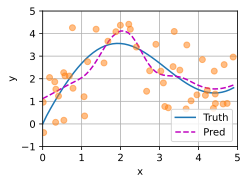

In [11]:
plot_kernel_reg(model.forward(data.x_val))

Comparing with nonparametric attention pooling,
[**the region with large attention weights becomes sharper**]
in the parametric setting.


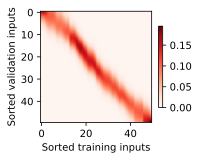

In [12]:
d2l.show_heatmaps([[model.attention_weights]],
                  xlabel='Sorted training inputs',
                  ylabel='Sorted validation inputs')

## Summary

* Nadaraya-Watson kernel regression is an example of machine learning with attention mechanisms.
* The attention pooling of Nadaraya-Watson kernel regression is a weighted average of the training outputs. From the attention perspective, the attention weight is assigned to a value based on a function of a query and the key that is paired with the value.
* Attention pooling can be either nonparametric or parametric.


## Exercises

1. Increase the number of training examples. Can you learn  nonparametric Nadaraya-Watson kernel regression better?
1. What is the value of our learned $w$ in the parametric attention pooling experiment? Why does it make the weighted region sharper when visualizing the attention weights?
1. How can we add hyperparameters to nonparametric Nadaraya-Watson kernel regression to predict better?
1. Design another parametric attention pooling for the kernel regression of this section. Train this new model and visualize its attention weights.


[Discussions](https://discuss.d2l.ai/t/3866)
